In [12]:
#CNN (-AKASH KUMAR)
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
#configuration of the neural network

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [3]:
#Load MNIST DATASET

from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [5]:
#check the total number of images for training and testing
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))
#validation set is not used in this program

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [6]:
#since the dataset set is one hot encoded we also need the real integer values
#so we convert the classes to integer too

data.test.cls = np.argmax(data.test.labels, axis=1)

In [8]:
#data about the images being used
# MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [9]:
#helper function to plot images not the partof main program--for visualizaton purpose only
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

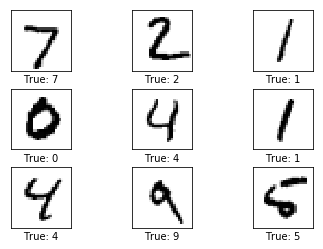

In [10]:
#check some data by plotting the images
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [14]:
#we use tensorflow because of computational graph it has and its effortless execution
#Also tensorflow automatically calculate the gradience and minimize it

In [16]:
#helper function to create new weights and biases

In [17]:
#create new random weights
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [18]:
#create new random bias
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [19]:
#function to create new CONVOLUTIONAL LAYER

#assumed that the INPUT is four dimension tensor whic are
# 1) Image number
# 2) Y-axis of each image
# 3) X-axis of each image
# 4) Channels for each image --which is 1 for grayscale image

# output is also a four dimesion tensor with the same attributes


def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling for decreasing the size of the image as it passes on.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # A bias-value is added to each filter-channel i.e., the result of the convolution
    layer += biases

    # pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and it is yet another activation function
    # used instead of sigmoid for better results. 
    # Relu makes sure that all the negative values become zero.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights --since we sill use the weights for plotting
    return layer, weights

In [20]:
# convolutional layer produces an output tensor with 4 dimensions. 
# We will add fully-connected layers after the convolution layers,
# so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.

# helper function for FLattening Layer

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features


In [21]:
# helper function for creating new fully connected layer
# the input is a 2-dim tensor of shape [num_images, num_inputs]
# the output is a 2-dim tensor of shape [num_images, num_outputs]

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer


In [22]:
#placeholder variable for input images
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [23]:
#convolutional layer expects the image to be of 4-dimension tensor, so we change it
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [25]:
#placeholder for the true labels--these are one hot encoded vectors of length 10
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [26]:
#placeholder variable for class number -- weuse argmax to get the class number
y_true_cls = tf.argmax(y_true, axis=1)

In [27]:
#create the first conv layer
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [28]:
#checking 1st layer
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [29]:
#create the 2nd conv layer
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [30]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [31]:
#now flatten the tensor before feeding it to the fully connected layer
layer_flat, num_features = flatten_layer(layer_conv2)

In [32]:
layer_flat


<tf.Tensor 'Reshape_2:0' shape=(?, 1764) dtype=float32>

In [33]:
num_features

1764

In [34]:
#fully connected layer1
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [35]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [36]:
#fully connected layer 2 with output of length 10
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [37]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [38]:
#now the output of the 2nd fully connected layer is a bit difficult to estimate because
#the numbers maybe too large or too small so to normalize it between 0 to 1  we use softmax
y_pred = tf.nn.softmax(layer_fc2)

In [40]:
# class number is the index of the largest element that is output from the softmax function.
y_pred_cls = tf.argmax(y_pred, axis=1)

In [41]:
#cross entropy is bascially the performance measure or the loss.
#since initially the data are initialised with random value
#our goal is to tweak those values so as to get the result or increase the accuracy of classification

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [42]:
#now we have the cross entropy of all the images but in order to use cross entropy to guide our model for optimization
#we need a sinfl=gle scalar value thus we take mean of it
cost = tf.reduce_mean(cross_entropy)

In [43]:
#Optimization.
#We use adam optimizer for optimization and decreasing the loss.
#adam_optimizer is just advance version of gradient descent.

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [44]:
#performance measure

In [45]:
#we need a few more performance measures to display the progress to the user.
#this is a vector of booleans whether the predicted class equals the true class of each image.
correct_prediction = tf.equal(y_pred_cls, y_true_cls)


In [46]:
#typecasting the vector of booleans to float of 0 and 1 for true and false respectively.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [47]:
# Run the tensorflow by creating session
session = tf.Session()


In [48]:
#initialize variables
session.run(tf.global_variables_initializer())

In [49]:
#helper function to perform optimizaton iteration
#we feed images in batch as it takes long to calculate the gradient of the model if w feed all 55000 images at once.

train_batch_size = 64

#function for performing number of optimization iterations
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # run the optimizer using this batch of training data.
        # tensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))



In [50]:
#function for plotting examples of images from the test-set that have been mis-classified.

def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [51]:
#helper function to plot confusion matrix

def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Making various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

In [52]:
#helper function for printing the classificaton accuracy on test set
#It takes a while to compute the classification for all the images in the test-set,
#that's why the results are re-used by calling the above functions directly from this function,
#so the classifications don't have to be recalculated by each function.

# Split the test-set into smaller batches of this size.
test_batch_size = 200

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
        

In [53]:
#without any optimization just check the accuracy at first
print_test_accuracy()

Accuracy on Test-Set: 10.1% (1011 / 10000)


In [54]:
#performance of the model after 1 iteration
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  12.5%
Time usage: 0:00:02


In [55]:
print_test_accuracy()

Accuracy on Test-Set: 9.6% (961 / 10000)


In [56]:
#performance after 100 optimization iterations
optimize(num_iterations=99) # already performed 1 iteraton, remember :p

Time usage: 0:00:14


Accuracy on Test-Set: 64.3% (6427 / 10000)
Example errors:


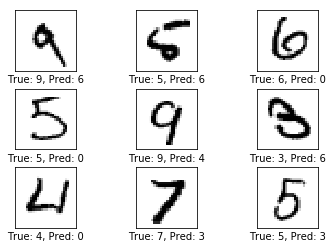

In [57]:
print_test_accuracy(show_example_errors=True)

In [58]:
#after 1000 optimization iterations
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:  76.6%
Optimization Iteration:    201, Training Accuracy:  81.2%
Optimization Iteration:    301, Training Accuracy:  85.9%
Optimization Iteration:    401, Training Accuracy:  87.5%
Optimization Iteration:    501, Training Accuracy:  87.5%
Optimization Iteration:    601, Training Accuracy:  79.7%
Optimization Iteration:    701, Training Accuracy:  95.3%
Optimization Iteration:    801, Training Accuracy:  93.8%
Optimization Iteration:    901, Training Accuracy:  95.3%
Time usage: 0:01:43


Accuracy on Test-Set: 93.2% (9324 / 10000)
Example errors:


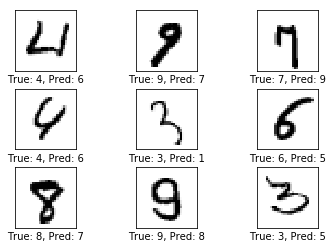

In [59]:
print_test_accuracy(show_example_errors=True)

In [60]:
#performance after 10,000 optimization iteration
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1001, Training Accuracy:  96.9%
Optimization Iteration:   1101, Training Accuracy:  98.4%
Optimization Iteration:   1201, Training Accuracy:  96.9%
Optimization Iteration:   1301, Training Accuracy:  93.8%
Optimization Iteration:   1401, Training Accuracy:  96.9%
Optimization Iteration:   1501, Training Accuracy:  93.8%
Optimization Iteration:   1601, Training Accuracy:  95.3%
Optimization Iteration:   1701, Training Accuracy:  93.8%
Optimization Iteration:   1801, Training Accuracy:  98.4%
Optimization Iteration:   1901, Training Accuracy: 100.0%
Optimization Iteration:   2001, Training Accuracy:  98.4%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy:  96.9%
Optimization Iteration:   2301, Training Accuracy:  95.3%
Optimization Iteration:   2401, Training Accuracy:  95.3%
Optimization Iteration:   2501, Training Accuracy: 100.0%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization I

Accuracy on Test-Set: 98.7% (9870 / 10000)
Example errors:


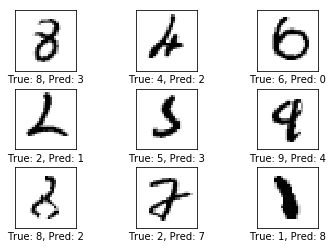

Confusion Matrix:
[[ 974    0    0    2    0    0    1    0    3    0]
 [   0 1130    1    0    1    0    0    0    3    0]
 [   1    2 1021    1    0    0    0    2    5    0]
 [   1    0    0 1006    0    0    0    1    2    0]
 [   0    1    1    0  978    0    0    0    0    2]
 [   1    0    0   12    0  875    1    0    1    2]
 [   9    3    0    0    5    5  934    0    2    0]
 [   0    4    7    1    0    0    0 1011    2    3]
 [   4    0    2    3    1    0    1    2  959    2]
 [   2    6    0    0   10    1    0    6    2  982]]


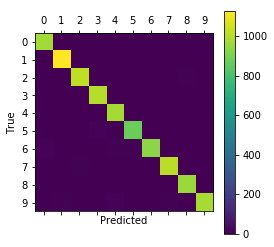

In [61]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

In [62]:
#visualization of weights and layers code (not exactly the part of core program)

In [64]:
#helper function for plotting the convolutional WEIGHTS

def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow outputs for 4-dim variables
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


In [65]:
#helper function for plotting Convolutional layer OUTPUT


def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

    

In [66]:
#helper function for plotting an image

def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

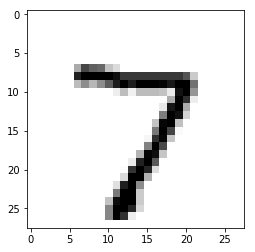

In [69]:
image1 = data.test.images[0]
plot_image(image1)

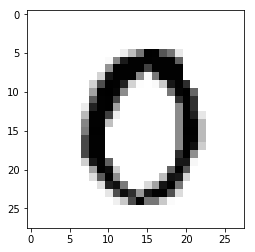

In [70]:
image2 = data.test.images[13]
plot_image(image2)

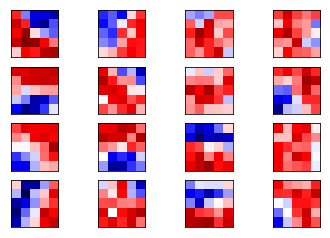

In [71]:
# Convolutional layer 1
#positive weights are red and negative weights are blue

plot_conv_weights(weights=weights_conv1)

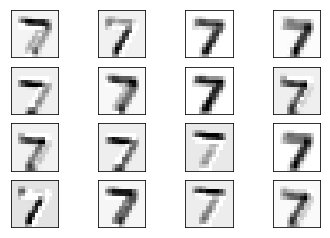

In [72]:
#the  above images are filters applied on the input image
plot_conv_layer(layer=layer_conv1, image=image1)

#the images below are result of applying the above filter to image 1
#the images  below are output of first 1st layer
#used as input for the 2nd convolutional layer

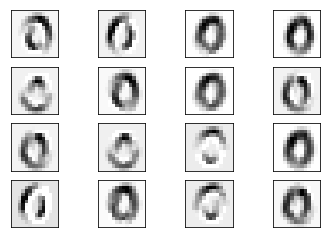

In [73]:
#images below are the results of applying the convolutional filters to the second image

plot_conv_layer(layer=layer_conv1, image=image2)

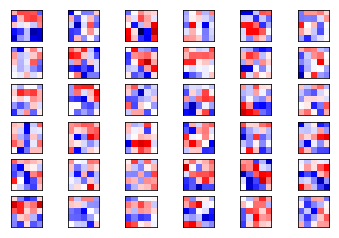

In [74]:
#plotting weight for the second convolutional layer
#there 16 output channel from 1st conv layer used as input for the 2nd conv layer
#there are 36 ouput channels for the 2nd conv layer
#positive weights are red and negative weights are blue

plot_conv_weights(weights=weights_conv2, input_channel=0)

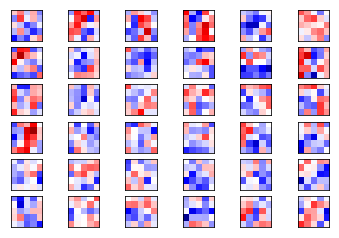

In [75]:
#similarly we we print weight for all the 16 channel 
#we print weight for the the 1st input channel

plot_conv_weights(weights=weights_conv2, input_channel=1)


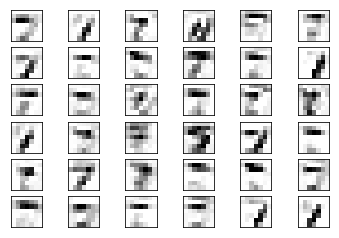

In [76]:
#applying the above convolution filters to the output images of first convolution layer
plot_conv_layer(layer=layer_conv2, image=image1)


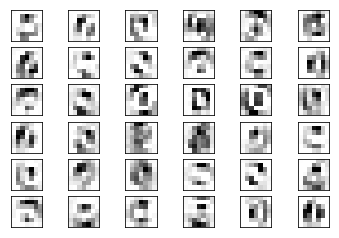

In [77]:
#similarly applying the filter weights to the 2nd image

plot_conv_layer(layer=layer_conv2, image=image2)


In [78]:
#although the images get more abstract and it's super difficult to understand how the network uses these images
#but  it looks like the second convolutional layer might detect lines and patterns in the input images,
#which are less sensitive to local variations in the original input images.

In [79]:
#close session
session.close()